In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2025-03-10 08:12:04 +08:00)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

time: 16 s (started: 2025-03-10 08:12:04 +08:00)


# Data Gathering

In [115]:
import pandas as pd
import yfinance as yf

# Ambil data dari Yahoo Finance untuk masing-masing ticker
gold_futures = yf.download('GC=F', start='2005-01-01', end='2025-03-07')['Close']
usd_idr_data = yf.download('IDR=X', start='2005-01-01', end='2025-03-07')['Close']
# bca_data = yf.download('BBCA.JK', start='2005-01-01', end='2025-03-07')['Close']
visa_data = yf.download('V', start='2005-01-01', end='2025-03-07')['Close']
apple_data = yf.download('AAPL', start='2005-01-01', end='2025-03-07')['Close']
msft_data = yf.download('MSFT', start='2005-01-01', end='2025-03-07')['Close']

# Gabungkan data ke dalam satu DataFrame dengan outer join
data = pd.concat([gold_futures, usd_idr_data, visa_data, apple_data, msft_data], axis=1, join='outer')

# Beri nama kolom
data.columns = ['Gold_Futures_USD', 'USD_IDR',  'Visa_USD', 'Apple_USD', 'MSFT_USD']

# Forward fill untuk menangani nilai kosong (jika ada)
data.ffill(inplace=True)

# Konversi harga emas dari USD/ons ke Rupiah/gram
data['Gold_Futures_IDR_per_gram'] = (data['Gold_Futures_USD'] * data['USD_IDR']) / 31.1035

# Konversi semua saham AS ke Rupiah
data['Visa_IDR'] = data['Visa_USD'] * data['USD_IDR']
data['Apple_IDR'] = data['Apple_USD'] * data['USD_IDR']
data['MSFT_IDR'] = data['MSFT_USD'] * data['USD_IDR']

# Hapus kolom harga saham dalam USD dan harga emas dalam USD
data = data.drop(['Gold_Futures_USD', 'Visa_USD', 'Apple_USD', 'MSFT_USD','MSFT_IDR','USD_IDR'], axis=1)

# Tampilkan DataFrame
print(data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

            Gold_Futures_IDR_per_gram  Visa_IDR    Apple_IDR
Date                                                        
2005-01-03              127942.211193       NaN  8839.934804
2005-01-04              127934.880878       NaN  8934.376342
2005-01-05              127255.140417       NaN  9004.666868
2005-01-06              125891.911343       NaN  9033.696840
2005-01-07              125103.671397       NaN  9679.049927
time: 500 ms (started: 2025-03-10 10:30:11 +08:00)


In [116]:
df = data.loc['2015-01-01':]
df

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2015-01-01,4.716036e+05,7.559961e+05,3.042241e+05
2015-01-02,4.724401e+05,7.641268e+05,3.013302e+05
2015-01-05,4.830541e+05,7.526881e+05,2.949684e+05
2015-01-06,4.949174e+05,7.565265e+05,2.984236e+05
2015-01-07,4.917752e+05,7.672699e+05,3.028478e+05
...,...,...,...
2025-02-28,1.509783e+06,6.004192e+06,4.003347e+06
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06


time: 31 ms (started: 2025-03-10 10:30:15 +08:00)


C:\Users\US3R\AppData\Local\Temp\ipykernel_9868\2029966536.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()



📌 Portofolio Risiko Minimum (MVP):
   Gold_Futures_IDR_per_gram: 71.47%
   Visa_IDR: 20.92%
   Apple_IDR: 7.61%
   Expected Return (Annual): 15.96%
   Risk (Standard Deviation, Annual): 16.04%


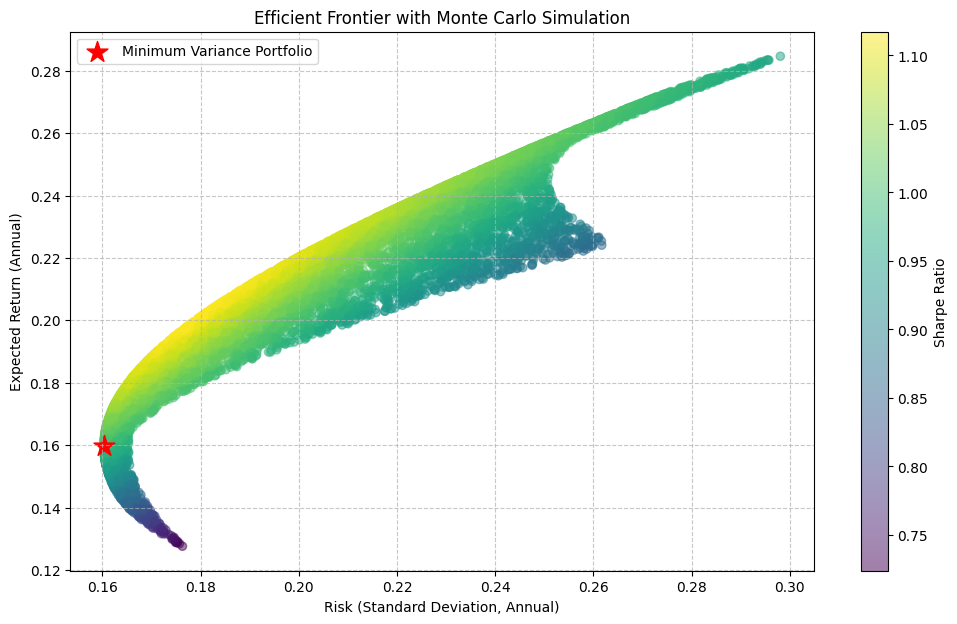

time: 3.31 s (started: 2025-03-10 10:30:27 +08:00)


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 🟢 1. Hitung return harian dengan handling NaN yang benar
returns = df.pct_change().fillna(method='ffill').dropna()

# 🟢 2. Hitung return ekspektasi dan matriks kovarians
expected_returns = returns.mean()
cov_matrix = returns.cov()

# 🟢 3. Fungsi untuk menghitung risiko portofolio (standard deviation)
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# 🟢 4. Optimasi untuk menemukan Minimum Variance Portfolio (MVP)
num_assets = len(expected_returns)
init_guess = np.ones(num_assets) / num_assets  # Bobot awal (rata)
bounds = [(0, 1) for _ in range(num_assets)]  # Setiap aset antara 0% - 100%
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Total bobot harus 100%

# Optimasi dengan SLSQP untuk meminimalkan risiko
optimal_result = minimize(
    portfolio_volatility, init_guess, args=(cov_matrix,),
    method='SLSQP', bounds=bounds, constraints=constraints
)
optimal_weights = optimal_result.x

# 🟢 5. Hitung return dan risiko portofolio MVP
min_var_return = np.sum(optimal_weights * expected_returns) * 252  # Skala tahunan
min_var_risk = portfolio_volatility(optimal_weights, cov_matrix) * np.sqrt(252)  # Skala tahunan

# 🟢 6. Cetak hasil MVP
print("\n📌 Portofolio Risiko Minimum (MVP):")
for asset, weight in zip(df.columns, optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return (Annual): {min_var_return:.2%}")
print(f"   Risk (Standard Deviation, Annual): {min_var_risk:.2%}")

# 🟢 7. Monte Carlo Simulation untuk Efficient Frontier
num_portfolios = 10000
risk_list = []
return_list = []
weights_list = []

for _ in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    port_return = np.sum(weights * expected_returns) * 252  # Skala tahunan
    port_risk = portfolio_volatility(weights, cov_matrix) * np.sqrt(252)  # Skala tahunan

    return_list.append(port_return)
    risk_list.append(port_risk)
    weights_list.append(weights)

# 🟢 8. Plot Efficient Frontier dengan Monte Carlo Simulation
plt.figure(figsize=(12, 7))
plt.scatter(risk_list, return_list, c=np.array(return_list)/np.array(risk_list), cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(min_var_risk, min_var_return, color='red', marker='*', s=250, label='Minimum Variance Portfolio')
plt.xlabel('Risk (Standard Deviation, Annual)')
plt.ylabel('Expected Return (Annual)')
plt.title('Efficient Frontier with Monte Carlo Simulation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Sharpe Ratio

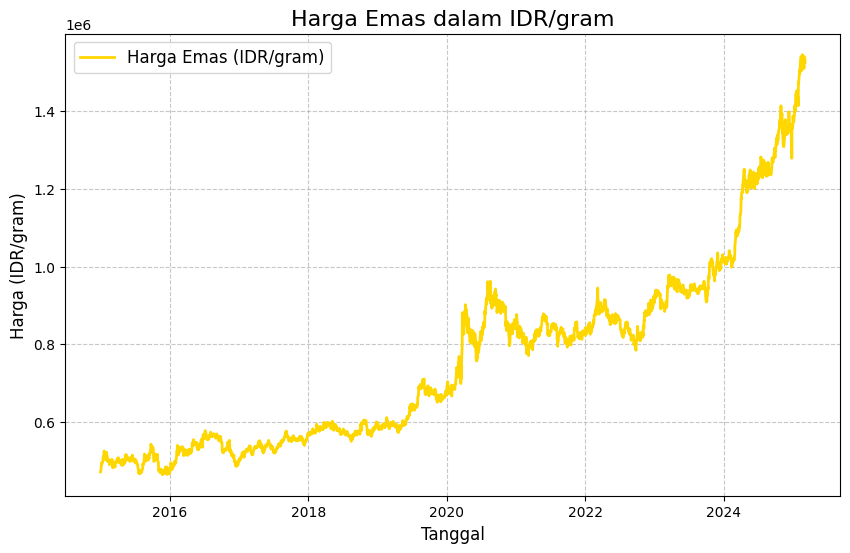

time: 234 ms (started: 2025-03-10 10:30:41 +08:00)


In [118]:
import matplotlib.pyplot as plt

# Asumsikan `df` adalah dfFrame yang sudah ada
plt.figure(figsize=(10, 6))  # Atur ukuran plot
plt.plot(df.index, df['Gold_Futures_IDR_per_gram'], label='Harga Emas (IDR/gram)', color='gold', linewidth=2)

# Atur judul dan label
plt.title('Harga Emas dalam IDR/gram', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (IDR/gram)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Tambahkan grid

# Tampilkan plot
plt.show()

In [119]:
df

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2015-01-01,4.716036e+05,7.559961e+05,3.042241e+05
2015-01-02,4.724401e+05,7.641268e+05,3.013302e+05
2015-01-05,4.830541e+05,7.526881e+05,2.949684e+05
2015-01-06,4.949174e+05,7.565265e+05,2.984236e+05
2015-01-07,4.917752e+05,7.672699e+05,3.028478e+05
...,...,...,...
2025-02-28,1.509783e+06,6.004192e+06,4.003347e+06
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06


time: 31 ms (started: 2025-03-10 10:30:43 +08:00)


C:\Users\US3R\AppData\Local\Temp\ipykernel_9868\4237891547.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()
Running Monte Carlo Simulation: 100%|██████████| 1000000/1000000 [08:36<00:00, 1934.33it/s]


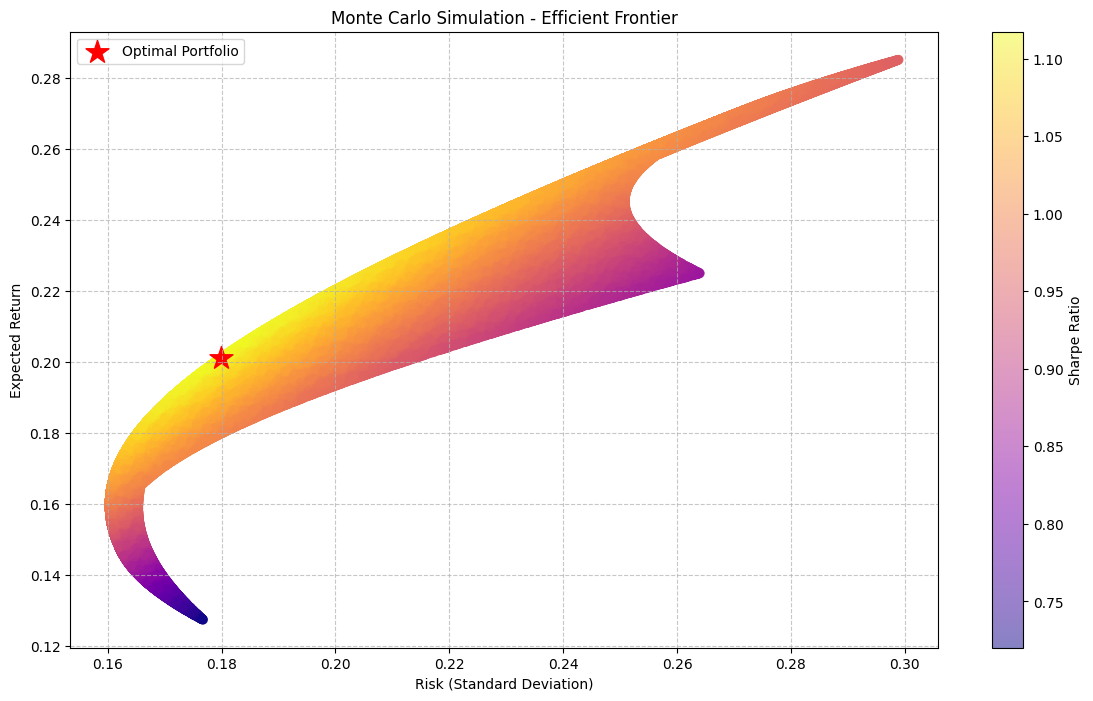


📌 Portofolio Optimal (Maksimum Sharpe Ratio):
   Gold_Futures_IDR_per_gram: 45.39%
   Visa_IDR: 20.60%
   Apple_IDR: 34.01%
   Expected Return: 20.10%
   Annual Expected Return: 20.10%
   Risk (Standard Deviation): 17.99%
   Sharpe Ratio: 1.12
time: 8min 59s (started: 2025-03-10 10:31:21 +08:00)


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm  # Import tqdm untuk progress bar

# Hitung return harian dengan menangani NaN lebih baik
returns = df.pct_change().fillna(method='ffill').dropna()

# Hitung return ekspektasi tahunan dan matriks kovarians
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Monte Carlo Simulation
num_assets = len(expected_returns)
num_portfolios = 1000000  # Jumlah simulasi Monte Carlo

results = np.zeros((4, num_portfolios))  # [Return, Risiko, Sharpe Ratio, Bobot]
weights_list = []

# Gunakan tqdm untuk progress bar
for i in tqdm(range(num_portfolios), desc="Running Monte Carlo Simulation"):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]  # Bobot portofolio
    weights_list.append(weights)

    port_return = np.sum(weights * expected_returns) * 252  # Skala ke tahunan
    port_risk = np.sqrt(weights.T @ cov_matrix @ weights * 252)  # Skala ke tahunan
    sharpe_ratio = port_return / port_risk if port_risk != 0 else 0  # Hindari div/0

    results[0, i] = port_return
    results[1, i] = port_risk
    results[2, i] = sharpe_ratio

# Mencari portofolio optimal (Maksimum Sharpe Ratio)
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_list[max_sharpe_idx]

# Hitung expected return tahunan untuk portofolio optimal
expected_return_optimal = np.sum(optimal_weights * expected_returns) * 252

# Visualisasi Monte Carlo Simulation
plt.figure(figsize=(14, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', marker='*', s=300, label='Optimal Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Monte Carlo Simulation - Efficient Frontier')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Output bobot optimal
print("\n📌 Portofolio Optimal (Maksimum Sharpe Ratio):")
for asset, weight in zip(['Gold_Futures_IDR_per_gram', 'Visa_IDR', 'Apple_IDR'], optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return: {results[0, max_sharpe_idx]:.2%}")
print(f"   Annual Expected Return: {expected_return_optimal:.2%}")
print(f"   Risk (Standard Deviation): {results[1, max_sharpe_idx]:.2%}")
print(f"   Sharpe Ratio: {results[2, max_sharpe_idx]:.2f}")



# Sharpe Ratio with T-Tails

C:\Users\US3R\AppData\Local\Temp\ipykernel_9868\1193603863.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()
Running Monte Carlo Simulation with Student's T: 100%|██████████| 1000000/1000000 [12:01<00:00, 1386.58it/s]
c:\Users\US3R\anaconda3\envs\Alwan\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


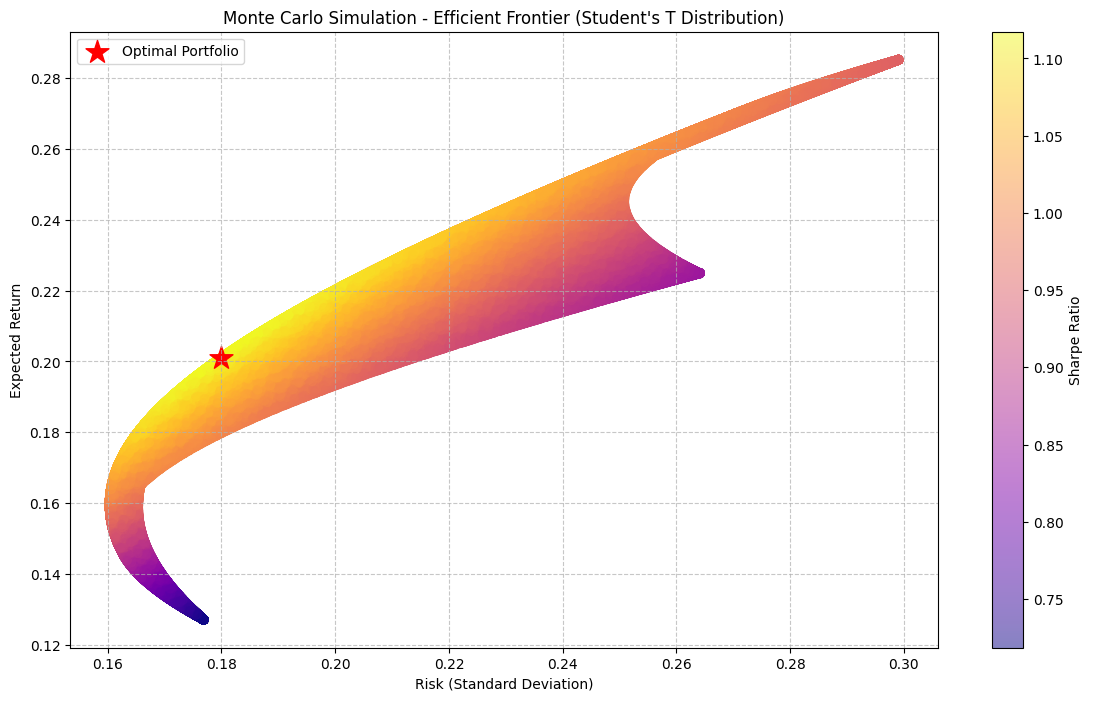


📌 Portofolio Optimal (Maksimum Sharpe Ratio) dengan Distribusi Student's T:
   Gold_Futures_IDR_per_gram: 45.40%
   Visa_IDR: 20.59%
   Apple_IDR: 34.01%
   Expected Return: 20.10%
   Annual Expected Return: 20.10%
   Risk (Standard Deviation): 17.99%
   Sharpe Ratio: 1.12
time: 12min 55s (started: 2025-03-10 10:40:20 +08:00)


In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from tqdm import tqdm  # Import tqdm untuk progress bar

# Dummy data: Return historis aset (gantilah dengan data asli)
np.random.seed(42)

# Hitung return harian dengan menangani NaN lebih baik
returns = df.pct_change().fillna(method='ffill').dropna()

# Hitung return ekspektasi tahunan dan matriks kovarians
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Monte Carlo Simulation dengan Student's T Distribution
num_assets = len(expected_returns)
num_portfolios = 1000000  # Jumlah simulasi Monte Carlo
df_t = 1  # Derajat kebebasan untuk distribusi Student's T (mengontrol ekor tebal)

results = np.zeros((4, num_portfolios))  # [Return, Risiko, Sharpe Ratio, Bobot]
weights_list = []

# Gunakan tqdm untuk progress bar
for i in tqdm(range(num_portfolios), desc="Running Monte Carlo Simulation with Student's T"):
    # Sampling bobot dengan distribusi Student's T
    raw_weights = np.abs(t.rvs(df_t, size=num_assets))  # Ambil nilai absolut agar tetap positif
    weights = raw_weights / np.sum(raw_weights)  # Normalisasi agar bobot total = 100%
    
    weights_list.append(weights)

    port_return = np.sum(weights * expected_returns) * 252  # Skala ke tahunan
    port_risk = np.sqrt(weights.T @ cov_matrix @ weights * 252)  # Skala ke tahunan
    sharpe_ratio = port_return / port_risk if port_risk != 0 else 0  # Hindari div/0

    results[0, i] = port_return
    results[1, i] = port_risk
    results[2, i] = sharpe_ratio

# Mencari portofolio optimal (Maksimum Sharpe Ratio)
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_list[max_sharpe_idx]

# Hitung expected return tahunan untuk portofolio optimal
expected_return_optimal = np.sum(optimal_weights * expected_returns) * 252

# Visualisasi Monte Carlo Simulation
plt.figure(figsize=(14, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', marker='*', s=300, label='Optimal Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title("Monte Carlo Simulation - Efficient Frontier (Student's T Distribution)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Output bobot optimal
print("\n📌 Portofolio Optimal (Maksimum Sharpe Ratio) dengan Distribusi Student's T:")
for asset, weight in zip(['Gold_Futures_IDR_per_gram', 'Visa_IDR', 'Apple_IDR'], optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return: {results[0, max_sharpe_idx]:.2%}")
print(f"   Annual Expected Return: {expected_return_optimal:.2%}")
print(f"   Risk (Standard Deviation): {results[1, max_sharpe_idx]:.2%}")
print(f"   Sharpe Ratio: {results[2, max_sharpe_idx]:.2f}")


In [108]:
optimal_weights

array([0.22598426, 0.28374281, 0.49027293])

time: 0 ns (started: 2025-03-10 10:19:14 +08:00)


In [109]:
custom_weight = np.array([0.57, 0.33, 0.10])

time: 0 ns (started: 2025-03-10 10:19:14 +08:00)


# Backtesting porto

In [125]:
data

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2005-01-03,1.279422e+05,NaN,8.839935e+03
2005-01-04,1.279349e+05,NaN,8.934376e+03
2005-01-05,1.272551e+05,NaN,9.004667e+03
2005-01-06,1.258919e+05,NaN,9.033697e+03
2005-01-07,1.251037e+05,NaN,9.679050e+03
...,...,...,...
2025-02-28,1.509783e+06,6.004192e+06,4.003347e+06
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06


time: 62 ms (started: 2025-03-10 14:54:16 +08:00)


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 🟢 1. AMBIL DATA HISTORIS 10 TAHUN TERAKHIR
ihsg = yf.download('^JKSE', start='2005-01-01', end='2025-03-07')['Close']
ihsg = ihsg.reindex(data.index).fillna(method='ffill')  # Sesuaikan dengan indeks `data`

new_data = data.copy()
new_data['IHSG'] = ihsg
new_data = new_data.loc['2005-06-01':]  # Hanya ambil 3 tahun terakhir

returns = new_data.pct_change().dropna()

# 🟢 2. BACKTEST PORTOFOLIO
def backtest_portfolio(weights, returns, start_date, end_date):
    if start_date == end_date:
        print("\n⚠️  Start date and end date cannot be the same!")
        return
    selected_returns = returns.loc[start_date:end_date]
    
    # Cek apakah data tersedia
    if selected_returns.empty:
        print(f"\n⚠️  Skipping {start_date} - {end_date}: No data available!")
        return
    
    portfolio_returns = (selected_returns[['Gold_Futures_IDR_per_gram','Visa_IDR','Apple_IDR']] @ weights).to_frame("Portfolio Return")
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    benchmark_returns = selected_returns[['IHSG', 'Gold_Futures_IDR_per_gram','Visa_IDR','Apple_IDR']]
    benchmark_cumulative = (1 + benchmark_returns).cumprod()
    
    # PLOT
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Optimal Portfolio', linewidth=2, color='black')
    plt.plot(benchmark_cumulative, linestyle='dashed')
    plt.legend(['Optimal Portfolio', 'IHSG', 'Gold', 'Visa', 'Apple'])
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.title(f'Backtest {start_date} - {end_date}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Kinerja Portofolio
    risk_free_rate = 0.03 / 252
    excess_returns = portfolio_returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / portfolio_returns.std() * np.sqrt(252)
    
    # Cek apakah cumulative_returns punya cukup data sebelum mengambil iloc[-1] dan iloc[0]
    if len(cumulative_returns) > 1:
        cagr = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(1/(len(selected_returns)/252)) - 1
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
        
        print(f"\n📌 Hasil Backtest ({start_date} - {end_date}):")
        print(f"   CAGR: {cagr.iloc[0]:.2%}")
        print(f"   Sharpe Ratio: {sharpe_ratio.iloc[0]:.2f}")
        print(f"   Max Drawdown: {max_drawdown.iloc[0]:.2%}")
    else:
        print(f"\n⚠️  Not enough data for {start_date} - {end_date} to calculate CAGR/Drawdown!")



[*********************100%***********************]  1 of 1 completed

time: 156 ms (started: 2025-03-10 14:54:17 +08:00)



C:\Users\US3R\AppData\Local\Temp\ipykernel_9868\589184890.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ihsg = ihsg.reindex(data.index).fillna(method='ffill')  # Sesuaikan dengan indeks `data`


('2025-01-01', '2025-03-07')
('2024-01-01', '2025-01-01')
('2024-01-01', '2024-01-01')
('2023-01-01', '2024-01-01')
('2022-01-01', '2023-01-01')
('2022-01-01', '2022-01-01')
('2021-01-01', '2022-01-01')
('2020-01-01', '2021-01-01')
('2019-01-01', '2020-01-01')
('2019-01-01', '2019-01-01')
('2018-01-01', '2019-01-01')
('2017-01-01', '2018-01-01')
('2016-01-01', '2017-01-01')
('2016-01-01', '2016-01-01')
('2015-01-01', '2016-01-01')
('2014-01-01', '2015-01-01')
('2013-01-01', '2014-01-01')
('2013-01-01', '2013-01-01')
('2012-01-01', '2013-01-01')
('2011-01-01', '2012-01-01')
('2010-01-01', '2011-01-01')


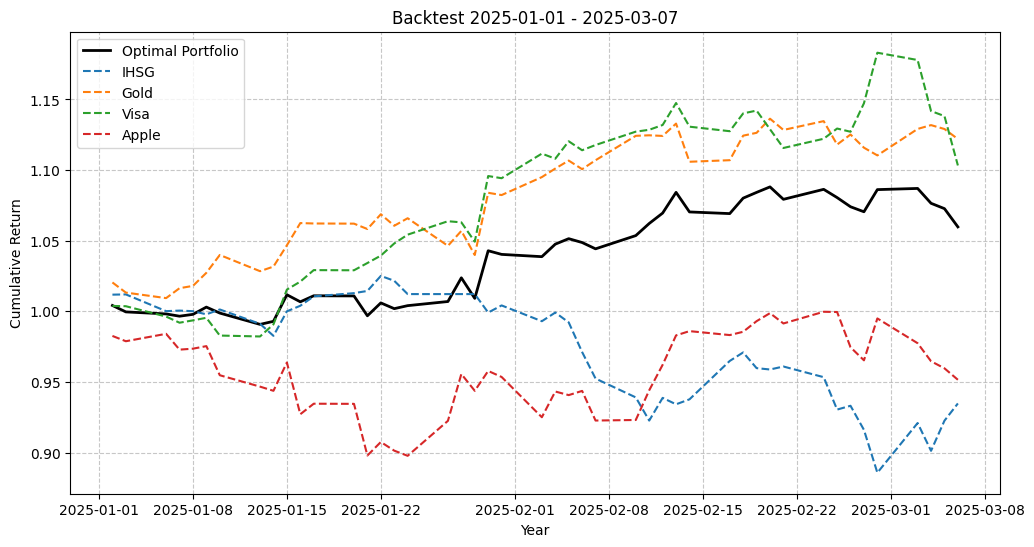


📌 Hasil Backtest (2025-01-01 - 2025-03-07):
   CAGR: 34.37%
   Sharpe Ratio: 2.04
   Max Drawdown: -2.60%


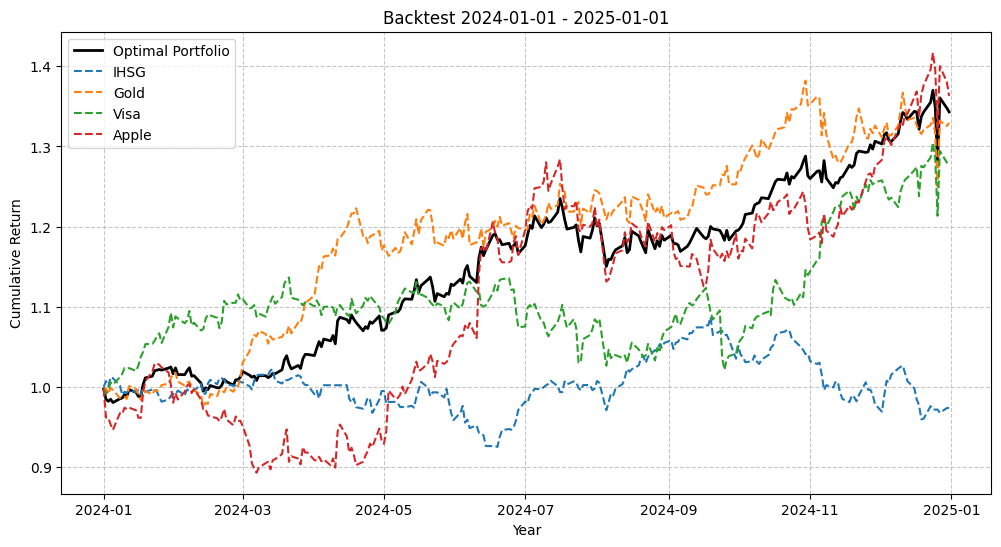


📌 Hasil Backtest (2024-01-01 - 2025-01-01):
   CAGR: 33.15%
   Sharpe Ratio: 1.70
   Max Drawdown: -6.87%

⚠️  Start date and end date cannot be the same!


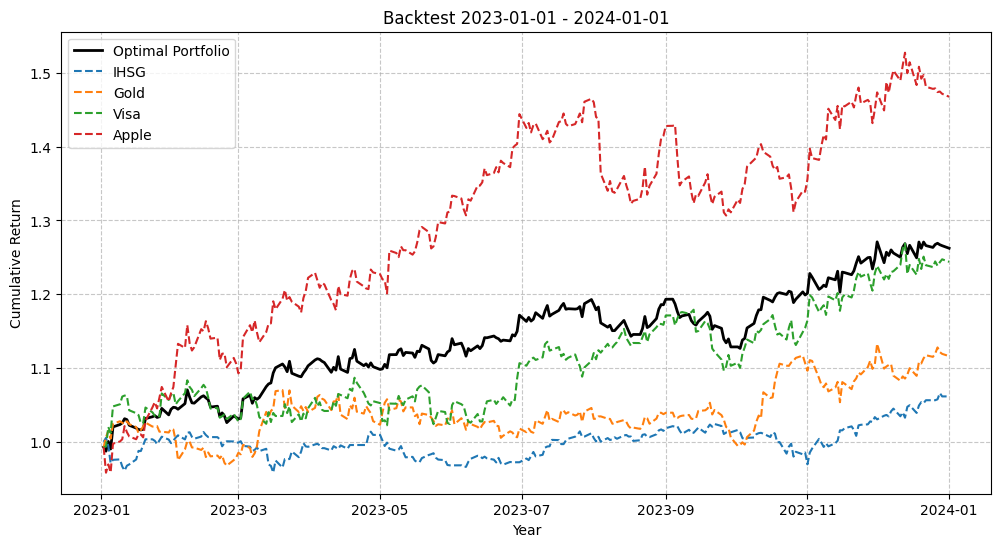


📌 Hasil Backtest (2023-01-01 - 2024-01-01):
   CAGR: 26.09%
   Sharpe Ratio: 1.60
   Max Drawdown: -5.59%


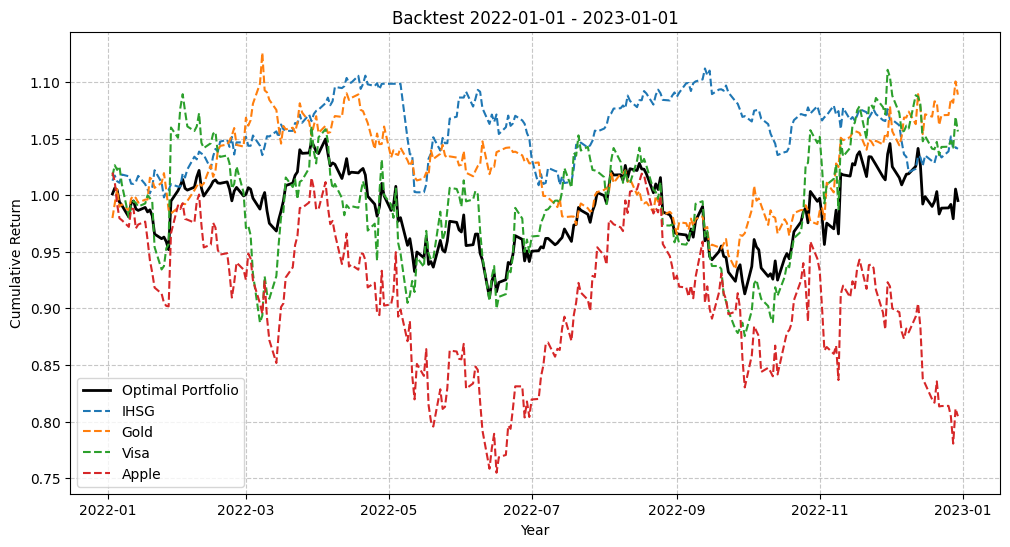


📌 Hasil Backtest (2022-01-01 - 2023-01-01):
   CAGR: -0.57%
   Sharpe Ratio: -0.08
   Max Drawdown: -13.37%

⚠️  Start date and end date cannot be the same!


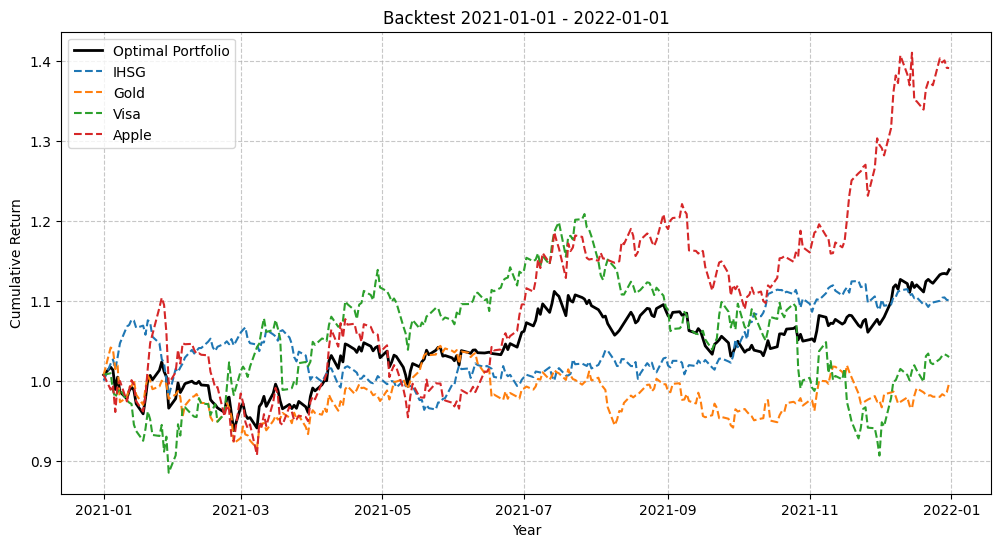


📌 Hasil Backtest (2021-01-01 - 2022-01-01):
   CAGR: 12.56%
   Sharpe Ratio: 0.69
   Max Drawdown: -8.38%


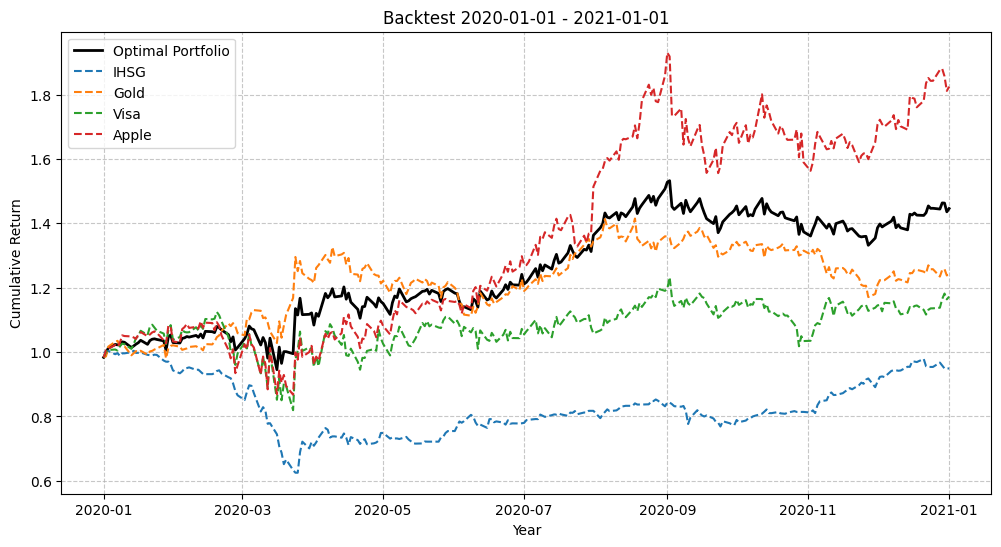


📌 Hasil Backtest (2020-01-01 - 2021-01-01):
   CAGR: 44.68%
   Sharpe Ratio: 1.12
   Max Drawdown: -13.10%


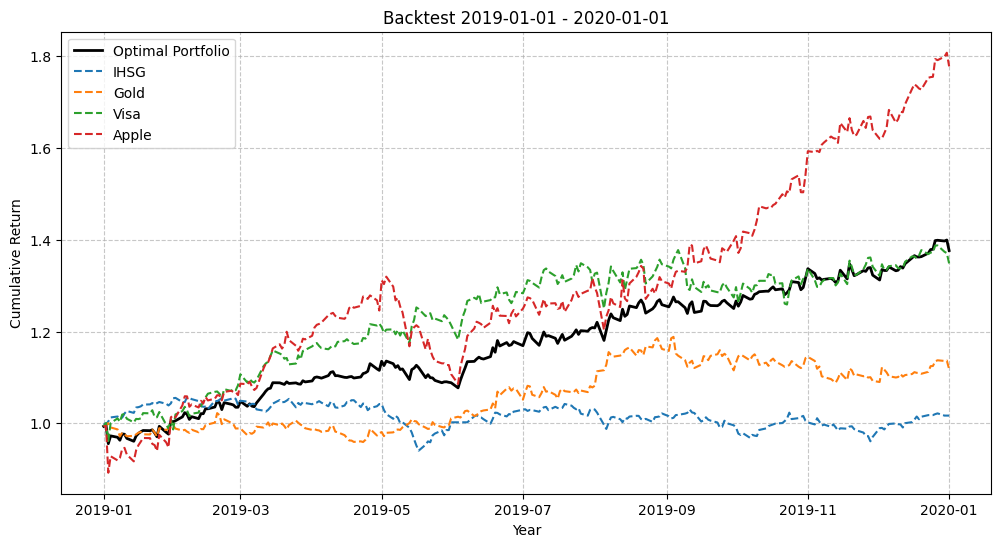


📌 Hasil Backtest (2019-01-01 - 2020-01-01):
   CAGR: 36.81%
   Sharpe Ratio: 1.99
   Max Drawdown: -5.14%

⚠️  Start date and end date cannot be the same!


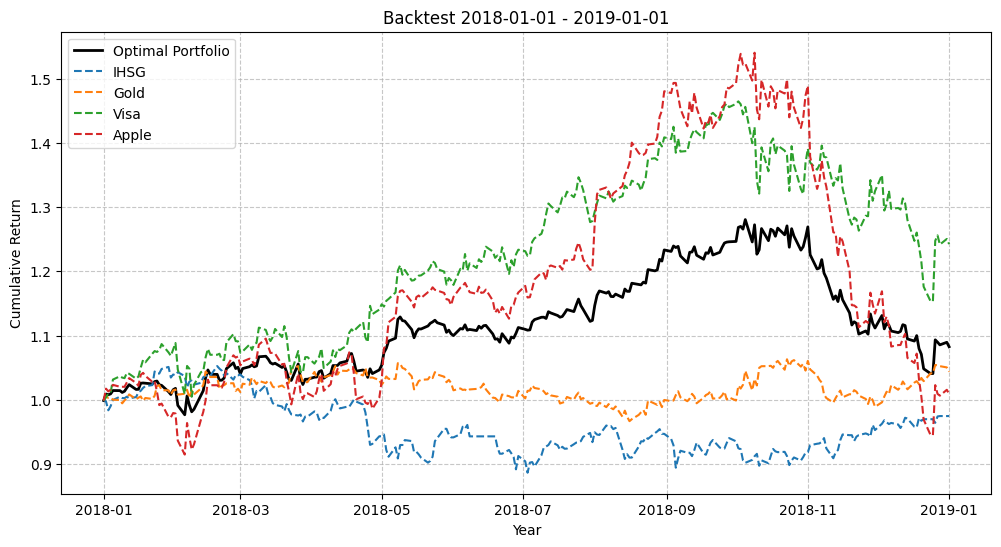


📌 Hasil Backtest (2018-01-01 - 2019-01-01):
   CAGR: 8.05%
   Sharpe Ratio: 0.36
   Max Drawdown: -18.72%


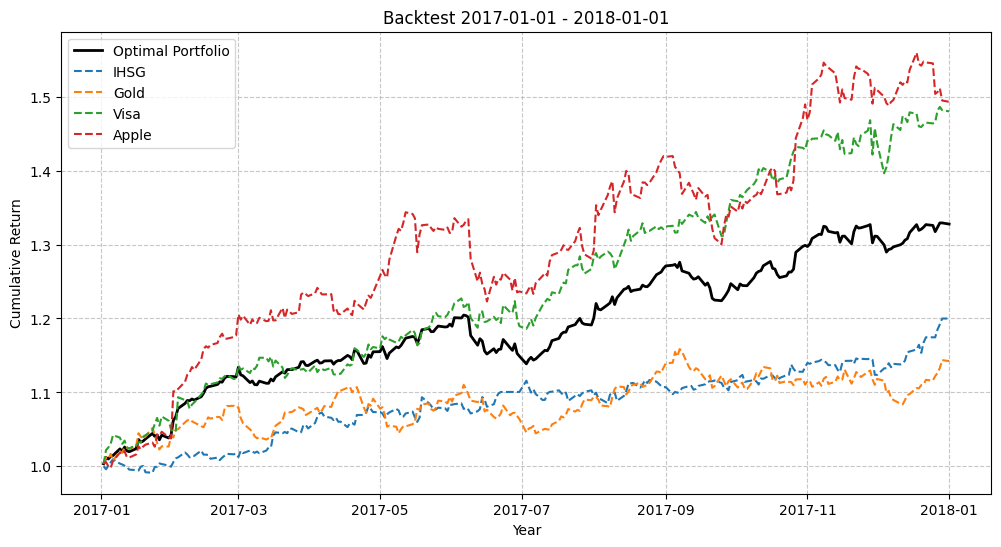


📌 Hasil Backtest (2017-01-01 - 2018-01-01):
   CAGR: 31.04%
   Sharpe Ratio: 2.83
   Max Drawdown: -5.48%


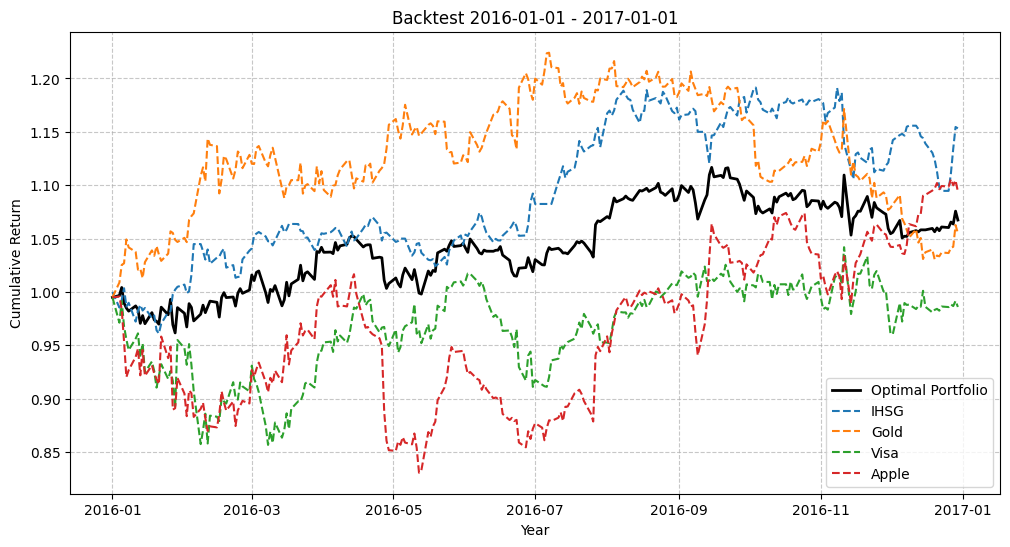


📌 Hasil Backtest (2016-01-01 - 2017-01-01):
   CAGR: 7.02%
   Sharpe Ratio: 0.30
   Max Drawdown: -5.92%

⚠️  Start date and end date cannot be the same!


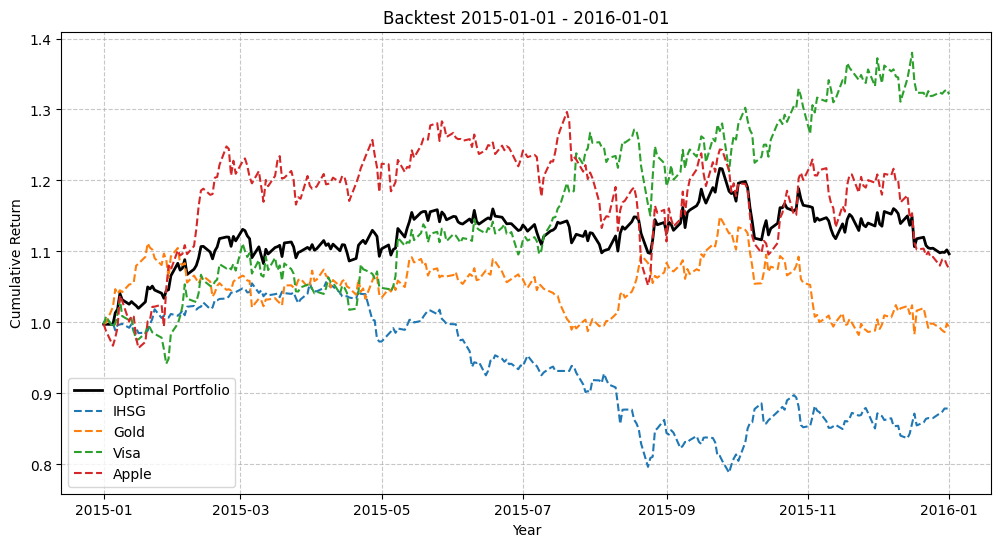


📌 Hasil Backtest (2015-01-01 - 2016-01-01):
   CAGR: 9.53%
   Sharpe Ratio: 0.43
   Max Drawdown: -9.89%


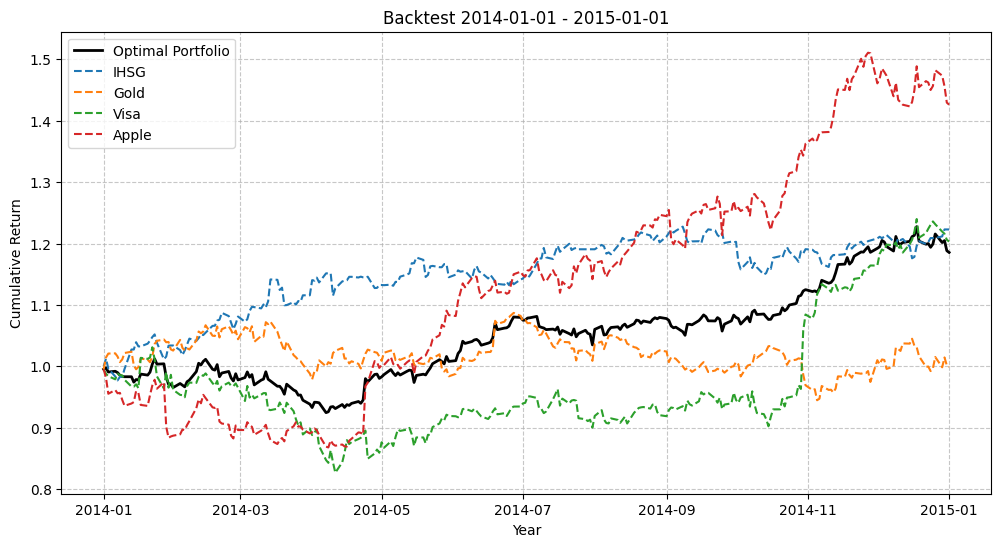


📌 Hasil Backtest (2014-01-01 - 2015-01-01):
   CAGR: 18.32%
   Sharpe Ratio: 1.14
   Max Drawdown: -8.65%


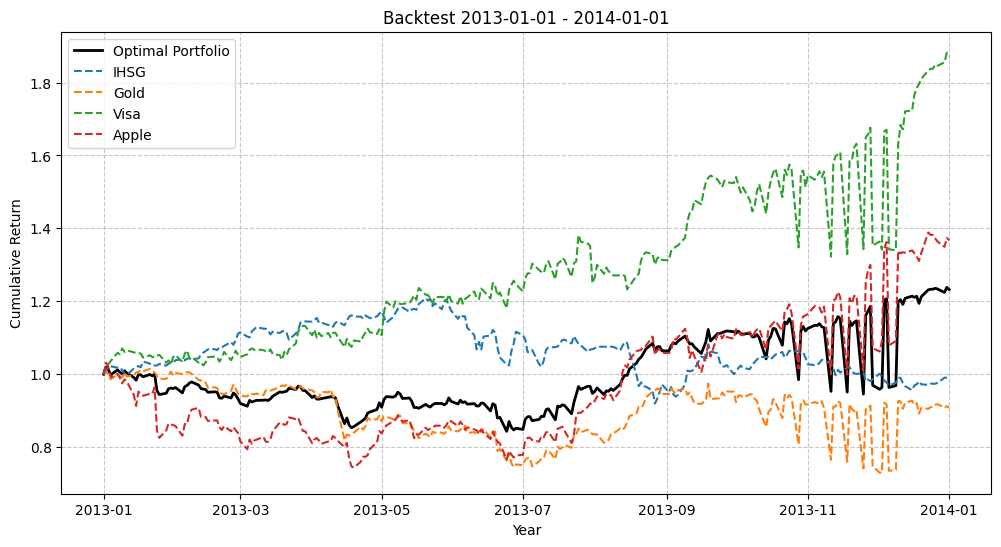


📌 Hasil Backtest (2013-01-01 - 2014-01-01):
   CAGR: 22.27%
   Sharpe Ratio: 0.59
   Max Drawdown: -20.16%

⚠️  Start date and end date cannot be the same!


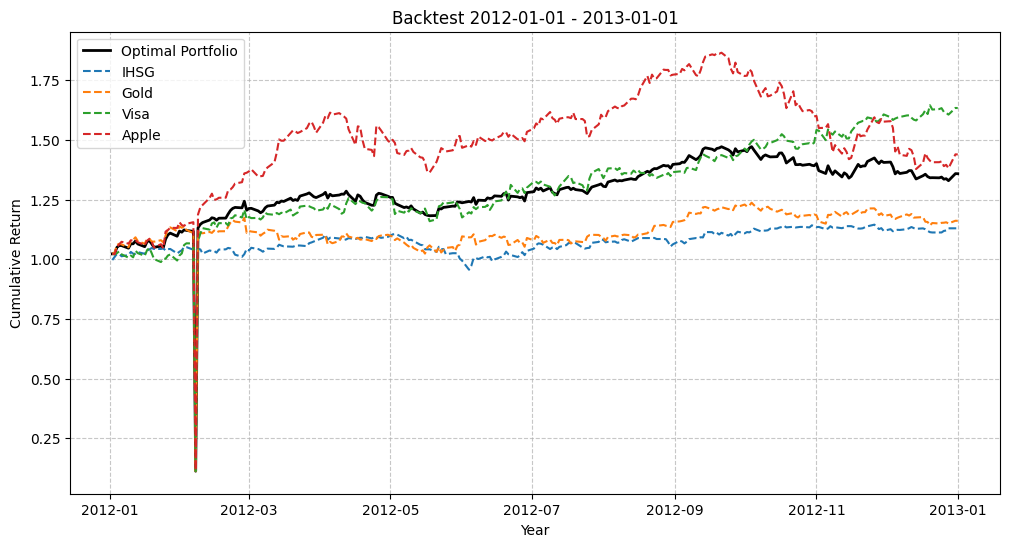


📌 Hasil Backtest (2012-01-01 - 2013-01-01):
   CAGR: 31.36%
   Sharpe Ratio: 0.91
   Max Drawdown: -89.97%


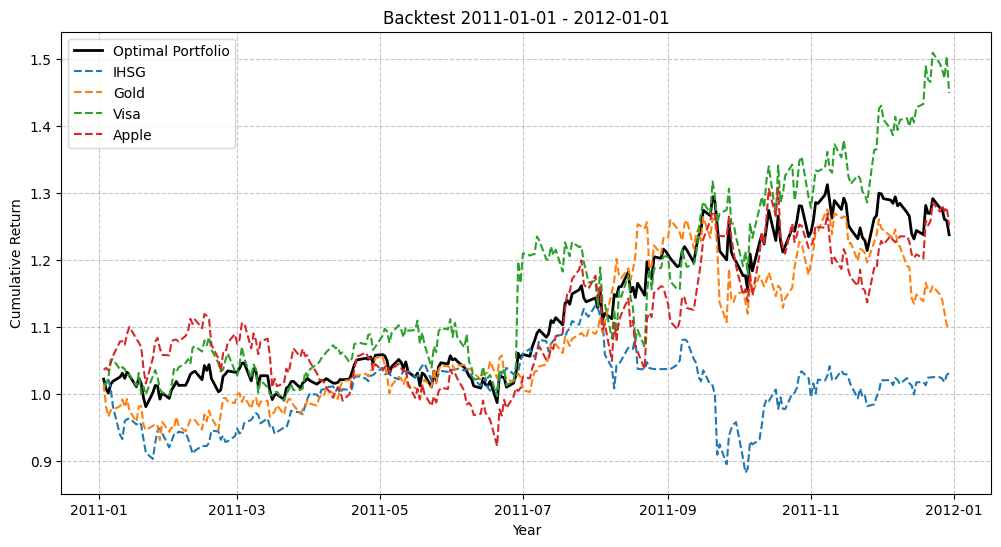


📌 Hasil Backtest (2011-01-01 - 2012-01-01):
   CAGR: 20.34%
   Sharpe Ratio: 0.87
   Max Drawdown: -10.76%


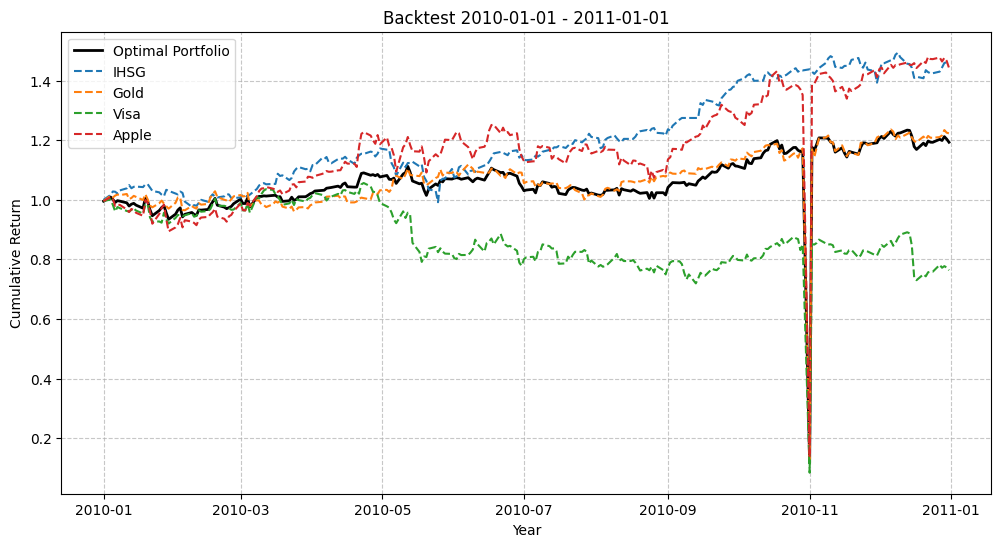


📌 Hasil Backtest (2010-01-01 - 2011-01-01):
   CAGR: 19.12%
   Sharpe Ratio: 0.90
   Max Drawdown: -90.31%
time: 5.56 s (started: 2025-03-10 14:54:17 +08:00)


In [127]:
test_periods = [
    ('2024-01-01', '2025-03-07'),
    ('2022-01-01', '2024-01-01'),
    ('2019-01-01', '2022-01-01'),
    ('2016-01-01', '2019-01-01'),
    ('2013-01-01', '2016-01-01'),
    ('2010-01-01', '2013-01-01')
]

def split_into_yearly_intervals(periods):
    yearly_intervals = []
    for start, end in periods:
        start_year = int(start[:4])
        end_year = int(end[:4])
        
        for year in range(start_year, end_year + 1):
            interval_start = f"{year}-01-01"
            interval_end = f"{year+1}-01-01" if year < end_year else end
            yearly_intervals.append((interval_start, interval_end))
    
    return yearly_intervals

# Membagi periode menjadi interval tahunan
yearly_intervals = split_into_yearly_intervals(test_periods)

# Mengurutkan interval tahunan dalam urutan menurun
yearly_intervals_sorted = sorted(yearly_intervals, key=lambda x: x[0], reverse=True)

# Menampilkan hasil
for interval in yearly_intervals_sorted:
    print(interval)


for start, end in yearly_intervals_sorted:
    backtest_portfolio(optimal_weights, returns, start, end)

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rolling_backtest(returns, weights, start_year, end_year, window=1):
    results = []
    for start in range(start_year, end_year - window):  # Rolling setiap tahun
        start_date = f"{start}-01-01"
        end_date = f"{start + window}-01-01"
        
        # Pilih periode sesuai window
        selected_returns = returns.loc[start_date:end_date]
        if selected_returns.empty:
            continue
        
        # Hitung metrik backtest
        portfolio_returns = (selected_returns[['Gold_Futures_IDR_per_gram','Visa_IDR','Apple_IDR']] @ weights)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        risk_free_rate = 0.03 / 252  # Asumsi 3% per tahun
        excess_returns = portfolio_returns - risk_free_rate
        sharpe_ratio = excess_returns.mean() / portfolio_returns.std() * np.sqrt(252)
        cagr = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(1/window) - 1
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
        
        results.append({
            "Period": f"{start}-{start + window}",
            "CAGR": cagr,
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": max_drawdown
        })
    
    return pd.DataFrame(results)

# Jalankan rolling backtest dari 2010 hingga 2025
df_results = rolling_backtest(returns, optimal_weights, 2010, 2026, window=1)
print(df_results)


       Period      CAGR  Sharpe Ratio  Max Drawdown
0   2010-2011  0.198615      0.897704     -0.903149
1   2011-2012  0.210526      0.874060     -0.107580
2   2012-2013  0.327940      0.908357     -0.899742
3   2013-2014  0.232533      0.585132     -0.201604
4   2014-2015  0.191155      1.136773     -0.086534
5   2015-2016  0.099303      0.434722     -0.098905
6   2016-2017  0.072800      0.303117     -0.059212
7   2017-2018  0.323146      2.830201     -0.054782
8   2018-2019  0.083789      0.356385     -0.187216
9   2019-2020  0.385212      1.991633     -0.051408
10  2020-2021  0.470348      1.115426     -0.130952
11  2021-2022  0.130409      0.692384     -0.083787
12  2022-2023 -0.005852     -0.080207     -0.133660
13  2023-2024  0.271349      1.603596     -0.055871
14  2024-2025  0.346692      1.700458     -0.068705
time: 63 ms (started: 2025-03-10 14:54:22 +08:00)


# Uji Stres

In [129]:
data

,Gold_Futures_IDR_per_gram,Visa_IDR,Apple_IDR
Date,,,
2005-01-03,1.279422e+05,NaN,8.839935e+03
2005-01-04,1.279349e+05,NaN,8.934376e+03
2005-01-05,1.272551e+05,NaN,9.004667e+03
2005-01-06,1.258919e+05,NaN,9.033697e+03
2005-01-07,1.251037e+05,NaN,9.679050e+03
...,...,...,...
2025-02-28,1.509783e+06,6.004192e+06,4.003347e+06
2025-03-03,1.535258e+06,5.977990e+06,3.932732e+06
2025-03-04,1.538940e+06,5.794606e+06,3.881331e+06


time: 32 ms (started: 2025-03-10 14:54:22 +08:00)


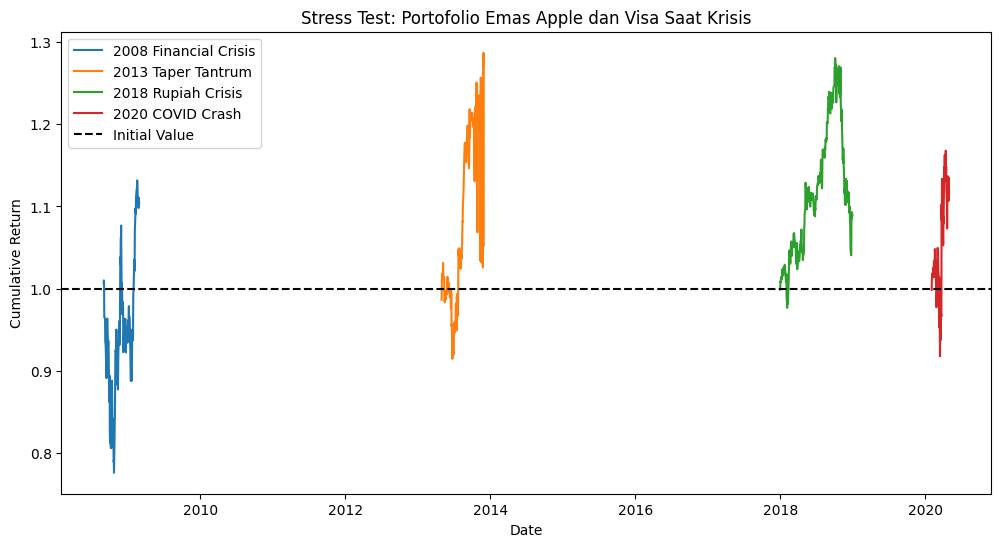

Return: 2008 Financial Crisis: 10.50%
Return: 2013 Taper Tantrum: 5.22%
Return: 2018 Rupiah Crisis: 8.95%
Return: 2020 COVID Crash: 11.77%
time: 219 ms (started: 2025-03-10 14:54:22 +08:00)


In [130]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# # Ambil data dari Yahoo Finance (GLD = emas, IDR=X = kurs USD/IDR)
# assets = ['GLD', 'IDR=X']
# data = yf.download(assets, start='2000-01-01', end='2025-03-05')['Close']

# Hitung return harian
returns = data.pct_change().dropna()

# Tentukan bobot portofolio berdasarkan hasil optimasi sebelumnya
weights = np.array([optimal_weights[0], optimal_weights[1],optimal_weights[2]])  # Bobot dari perhitungan sebelumnya

# Hitung return portofolio
portfolio_returns = returns.dot(weights)

# Periode krisis besar
crisis_periods = {
    "2008 Financial Crisis": ('2008-09-01', '2009-03-01'),
    "2013 Taper Tantrum": ('2013-05-01', '2013-12-01'),
    "2018 Rupiah Crisis": ('2018-01-01', '2018-12-31'),
    "2020 COVID Crash": ('2020-02-01', '2020-05-01')
}

# Visualisasi performa portofolio saat krisis
plt.figure(figsize=(12, 6))

for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns.loc[start:end]
    plt.plot(crisis_data.index, (1 + crisis_data).cumprod(), label=crisis)

plt.axhline(y=1, color='black', linestyle='--', label="Initial Value")
plt.legend()
plt.title("Stress Test: Portofolio Emas Apple dan Visa Saat Krisis")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()

# Menampilkan return selama krisis
for crisis, (start, end) in crisis_periods.items():
    crisis_return = (1 + portfolio_returns.loc[start:end]).cumprod().iloc[-1] - 1
    print(f"Return: {crisis}: {crisis_return:.2%}")


2008 Financial Crisis: CAGR = 20.98%
2013 Taper Tantrum: CAGR = 11.73%
2018 Rupiah Crisis: CAGR = 9.11%
2020 COVID Crash: CAGR = 59.64%


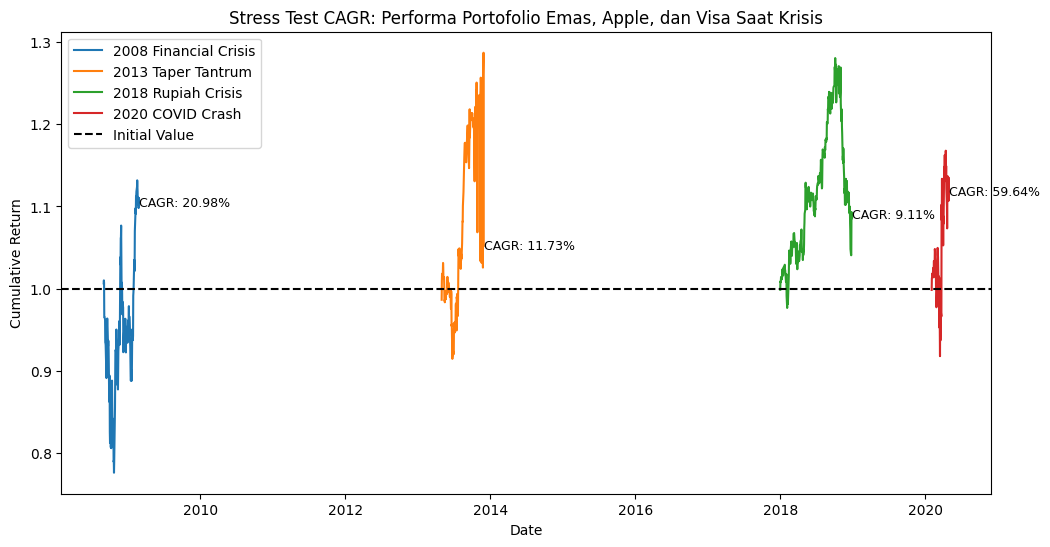

time: 234 ms (started: 2025-03-10 14:54:23 +08:00)


In [131]:
def calculate_cagr(begin_value, end_value, periods):
    return (end_value / begin_value) ** (1 / periods) - 1

for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns.loc[start:end]
    begin_value = (1 + crisis_data).cumprod().iloc[0]
    end_value = (1 + crisis_data).cumprod().iloc[-1]
    num_years = (crisis_data.index[-1] - crisis_data.index[0]).days / 365.25
    cagr = calculate_cagr(begin_value, end_value, num_years)
    print(f"{crisis}: CAGR = {cagr:.2%}")

plt.figure(figsize=(12, 6))

for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns.loc[start:end]
    cumulative_returns = (1 + crisis_data).cumprod()
    plt.plot(cumulative_returns.index, cumulative_returns, label=crisis)
    begin_value = cumulative_returns.iloc[0]
    end_value = cumulative_returns.iloc[-1]
    num_years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    cagr = calculate_cagr(begin_value, end_value, num_years)
    plt.text(cumulative_returns.index[-1], end_value, f'CAGR: {cagr:.2%}', fontsize=9, verticalalignment='center')

plt.axhline(y=1, color='black', linestyle='--', label="Initial Value")
plt.legend()
plt.title("Stress Test CAGR: Performa Portofolio Emas, Apple, dan Visa Saat Krisis")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()


# CVar Risk Analysis

Ini adalah rumus inline: $E = mc^2$


### **Definisi, Maksud, dan Tujuan CVaR (Conditional Value at Risk)**  

#### **📌 Definisi CVaR**  
Conditional Value at Risk (CVaR), juga disebut **Expected Shortfall (ES)**, adalah ukuran risiko yang menghitung **kerugian rata-rata** dalam skenario ekstrem yang berada di luar ambang batas Value at Risk (VaR).  

Matematis, jika kita memiliki tingkat kepercayaan $\alpha$ (misalnya 95%), maka:  


$\text{CVaR}_\alpha = \mathbb{E} [ X | X \leq \text{VaR}_\alpha ]$


Artinya, CVaR adalah **rata-rata kerugian yang lebih besar dari VaR**.


---

#### **🎯 Maksud CVaR**  
CVaR memperbaiki kelemahan VaR, karena:  
✅ **Menangkap tail risk** – VaR hanya menunjukkan batas kerugian tanpa memperhitungkan seberapa parah kerugian yang mungkin terjadi.  
✅ **Lebih stabil dibanding VaR** – CVaR tidak rentan terhadap perubahan kecil dalam distribusi return.  
✅ **Cocok untuk skenario Black Swan** – CVaR dapat menangkap kerugian ekstrem dalam distribusi return yang heavy-tailed (seperti distribusi Student’s T).  

---

#### **🏆 Tujuan CVaR**  
1️⃣ **Mengukur risiko ekstrem dengan lebih akurat dibandingkan VaR.**  
2️⃣ **Digunakan dalam manajemen risiko keuangan** untuk menghindari kejutan besar dalam portofolio investasi.  
3️⃣ **Membantu strategi alokasi aset** agar lebih tahan terhadap skenario pasar yang buruk.  

---

#### **🛠️ Kesimpulan**  
CVaR lebih baik dibandingkan VaR karena **tidak hanya memberi tahu batas kerugian (VaR), tetapi juga berapa besar rata-rata kerugian di skenario terburuk**. Oleh karena itu, **lebih direkomendasikan untuk analisis risiko di pasar keuangan yang rentan terhadap krisis**. 🚀

In [132]:
import numpy as np
import scipy.stats as stats

# Parameter simulasi
np.random.seed(42)
n_simulations = 50000
alpha = 0.1  # Confidence level 95%

# Distribusi Student's T
nu = 2  # Degree of freedom
simulated_returns_t = stats.t.rvs(df=nu, size=n_simulations)

# Distribusi Normal untuk perbandingan
simulated_returns_norm = np.random.normal(size=n_simulations)

# Hitung Value at Risk (VaR)
VaR_t = np.percentile(simulated_returns_t, 100 * alpha)
VaR_norm = np.percentile(simulated_returns_norm, 100 * alpha)

# Hitung Conditional Value at Risk (CVaR)
CVaR_t = simulated_returns_t[simulated_returns_t <= VaR_t].mean()
CVaR_norm = simulated_returns_norm[simulated_returns_norm <= VaR_norm].mean()

print(f"VaR (Student's T, alpha={alpha}): {VaR_t:.4f}")
print(f"VaR (Normal, alpha={alpha}): {VaR_norm:.4f}")
print(f"CVaR (Student's T, alpha={alpha}): {CVaR_t:.4f}")
print(f"CVaR (Normal, alpha={alpha}): {CVaR_norm:.4f}")


VaR (Student's T, alpha=0.1): -1.8604
VaR (Normal, alpha=0.1): -1.2772
CVaR (Student's T, alpha=0.1): -4.1333
CVaR (Normal, alpha=0.1): -1.7536
time: 15 ms (started: 2025-03-10 14:54:23 +08:00)
